Feature ranking and automatic feature selection
-----------------------------------------------

This notebook generates multiple feature importance scores, ranks the features
and automatically suggests a feature selection based on the majority vote of all models.

The following six models for feature importance scoring are included:
- Spearman rank analysis (see 'selectio.models.spearman')
- Correlation coefficient significance of linear/log-scaled Bayesian Linear Regression (see 'selectio.models.blr')
- Random Forest Permutation test (see 'selectio.models.rf.py')
- Random Decision Trees on various subsamples of data (see 'selectio.models.rdt.py')
- Mutual Information Regression (see 'selectio.models.mi')
- General correlation coefficients (see 'selectio.models.xicor')

This notebook generate synthetic test data but can be used with any tabulated data or dataframes.

User settings, such as input/output paths and all other options, are set in the settings file 
(Default filename: settings_featureimportance.yaml) 
Alternatively, the settings file can be specified as a command line argument with: 
'-s', or '--settings' followed by PATH-TO-FILE/FILENAME.yaml 
(e.g. python featureimportance.py -s settings_featureimportance.yaml).

Requirements:
- selectio
- matplotlib
- pyyaml
- pandas

This package is part of the machine learning project developed for the Agricultural Research Federation (AgReFed).



### Import libraries

In [2]:
import os 
import yaml
import shutil
import numpy as np
import pandas as pd
import importlib
import pkg_resources
import matplotlib.pyplot as plt

# Import selection package:
from selectio import selectio
from selectio.simdata import create_simulated_features
from selectio.utils import plot_correlationbar, plot_feature_correlation_spearman, gradientbars

### Define output directory

In [3]:
# Generate result folder and name of settings file to save configuration
outpath = 'testresults_feature_selection'
os.makedirs(outpath, exist_ok = True)
fname_settings = 'settings_featureimportance_simulation.yaml'

### Generate synthetic test data

In [4]:
 # This function generates simulated data with added noise 
 # and automatically saves data and coefficients in output directory as csv files
 dfsim, coefsim, feature_names_sim = create_simulated_features(n_features=8,
  outpath = outpath,
  n_samples = 200,
  model_order='quadratic',
  noise=0.1)

print(f'Saved generated data in directory {outpath} with files:')
[print(filename) for filename in os.listdir(outpath)]

#print true simulated feature coefficients
print('')
print('True feature coefficients:')
[print(f'{feature_names_sim[i]}: {coefsim[i]:.4f}') for i in  range(len(feature_names_sim))]

# print generated dataframe header 
print('')
print('Dataframe header extract: ')
dfsim.head()

Saved generated data in directory testresults_feature_selection with files:
Models-feature-importances.png
Feature_Correlations_Hierarchical_Spearman.png
Combined-feature-importance.png
SyntheticData_coefficients_quadratic_8nfeatures_0.1noise.csv
settings_feature_selection_sim.yaml
SyntheticData_quadratic_8nfeatures_0.1noise.csv
feature-importance_scores.csv

True feature coefficients:
Feature_1: 0.8064
Feature_2: 0.4592
Feature_3: 0.0520
Feature_4: 0.7863
Feature_5: 0.0000
Feature_6: 0.0000
Feature_7: 0.0000
Feature_8: 0.0000

Dataframe header extract: 


,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Ytarget
0,0.596084,0.364148,0.630799,0.785936,0.478162,0.484203,0.762716,0.686075,2.362816
1,0.403859,0.472618,0.416293,0.430320,0.572361,0.178790,0.239923,0.438761,1.501208
2,0.295757,0.436243,0.330459,0.261060,0.814465,0.485724,0.523531,0.278352,0.957155
3,0.388956,0.403849,0.283552,0.580778,0.405654,0.473734,0.417642,0.887844,1.570831
4,0.494576,0.217660,0.664557,0.295295,0.565812,0.170352,0.302696,0.579954,1.182988


## Option 1: Run feature selection with settings file

### A) Generate Settings YAML file

In [5]:
# define settings name
fname_settings_sim = 'settings_feature_selection_sim.yaml'
# generate settings template
shutil.copyfile(selectio._fname_settings, os.path.join(outpath, fname_settings_sim))
with open(os.path.join(outpath, fname_settings_sim), 'r') as f:
    settings_sim = yaml.load(f, Loader=yaml.FullLoader)
settings_sim['name_features'] = feature_names_sim
settings_sim['name_target'] = 'Ytarget'
settings_sim['infname'] = 'SyntheticData_quadratic_8nfeatures_0.1noise.csv'
settings_sim['inpath'] = outpath
settings_sim['outpath'] = outpath
settings_path = os.path.join(outpath, fname_settings_sim)
print('Saving settings in: ', settings_path)
with open(settings_path, 'w') as f:
    yaml.dump(settings_sim, f)

print('Settings:')
[print(f'{keys}: {values}') for keys, values in settings_sim.items()]

Saving settings in:  testresults_feature_selection/settings_feature_selection_sim.yaml
Settings:
inpath: testresults_feature_selection
infname: SyntheticData_quadratic_8nfeatures_0.1noise.csv
outpath: testresults_feature_selection
name_target: Ytarget
name_features: ['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8']


[None, None, None, None, None]

### B) Run automatic feature selection and plotting

In [6]:
# Run selectio main 
selectio.main(settings_path)

Calculate Spearman correlation matrix...
Computing scores for model spearman...
Done, 3 features selected.
Computing scores for model mi...
Done, 6 features selected.
Computing scores for model xicor...
Done, 2 features selected.
Computing scores for model blr...
Done, 3 features selected.
Computing scores for model rf...
Done, 3 features selected.
Computing scores for model rdt...
Done, 8 features selected.
Feature selection: 
  name_features  score_combined
3     Feature_4          0.4611
0     Feature_1          0.3930
1     Feature_2          0.0994
Generating overview score plots ...
COMPLETED.


In [7]:
# list created files
[print(filename) for filename in os.listdir(outpath)]

Models-feature-importances.png
Feature_importance_map.png
Feature_Correlations_Hierarchical_Spearman.png
Combined-feature-importance.png
SyntheticData_coefficients_quadratic_8nfeatures_0.1noise.csv
settings_feature_selection_sim.yaml
SyntheticData_quadratic_8nfeatures_0.1noise.csv
feature-importance_scores.csv
Feature_importances_all.png


[None, None, None, None, None, None, None, None, None]

### C) Read dataframe of computed feature importance scores

In [8]:
dfresults = pd.read_csv(os.path.join(outpath,'feature-importance_scores.csv'), index_col='Feature_index')
dfresults

,name_features,score_spearman,score_mi,score_xicor,score_blr,score_rf,score_rdt,woe_spearman,woe_mi,woe_xicor,woe_blr,woe_rf,woe_rdt,score_combined,selected
Feature_index,,,,,,,,,,,,,,,
0,Feature_1,0.3799,0.3447,0.4269,0.3845,0.4301,0.3920,1,1,1,1,1,1,0.3930,1
1,Feature_2,0.1987,0.0441,0.0000,0.2072,0.0531,0.0932,1,1,0,1,1,1,0.0994,1
2,Feature_3,0.0000,0.0320,0.0000,0.0000,0.0000,0.0161,0,1,0,0,0,1,0.0080,0
3,Feature_4,0.4214,0.4104,0.5731,0.4082,0.5167,0.4365,1,1,1,1,1,1,0.4611,1
4,Feature_5,0.0000,0.1247,0.0000,0.0000,0.0000,0.0146,0,1,0,0,0,1,0.0232,0
5,Feature_6,0.0000,0.0000,0.0000,0.0000,0.0000,0.0170,0,0,0,0,0,1,0.0028,0
6,Feature_7,0.0000,0.0000,0.0000,0.0000,0.0000,0.0166,0,0,0,0,0,1,0.0028,0
7,Feature_8,0.0000,0.0441,0.0000,0.0000,0.0000,0.0140,0,1,0,0,0,1,0.0097,0


In [9]:
# Show selected features only
dfresults[dfresults.selected == 1].sort_values('score_combined', ascending=False)

,name_features,score_spearman,score_mi,score_xicor,score_blr,score_rf,score_rdt,woe_spearman,woe_mi,woe_xicor,woe_blr,woe_rf,woe_rdt,score_combined,selected
Feature_index,,,,,,,,,,,,,,,
3,Feature_4,0.4214,0.4104,0.5731,0.4082,0.5167,0.4365,1,1,1,1,1,1,0.4611,1
0,Feature_1,0.3799,0.3447,0.4269,0.3845,0.4301,0.3920,1,1,1,1,1,1,0.3930,1
1,Feature_2,0.1987,0.0441,0.0000,0.2072,0.0531,0.0932,1,1,0,1,1,1,0.0994,1


## Option 2: Manual Walkthrough 

In [10]:
# Data
X = dfsim[feature_names_sim].values
y = dfsim['Ytarget'].values

### Generate Spearman correlation matrix for X

Calculate Spearman correlation matrix ...


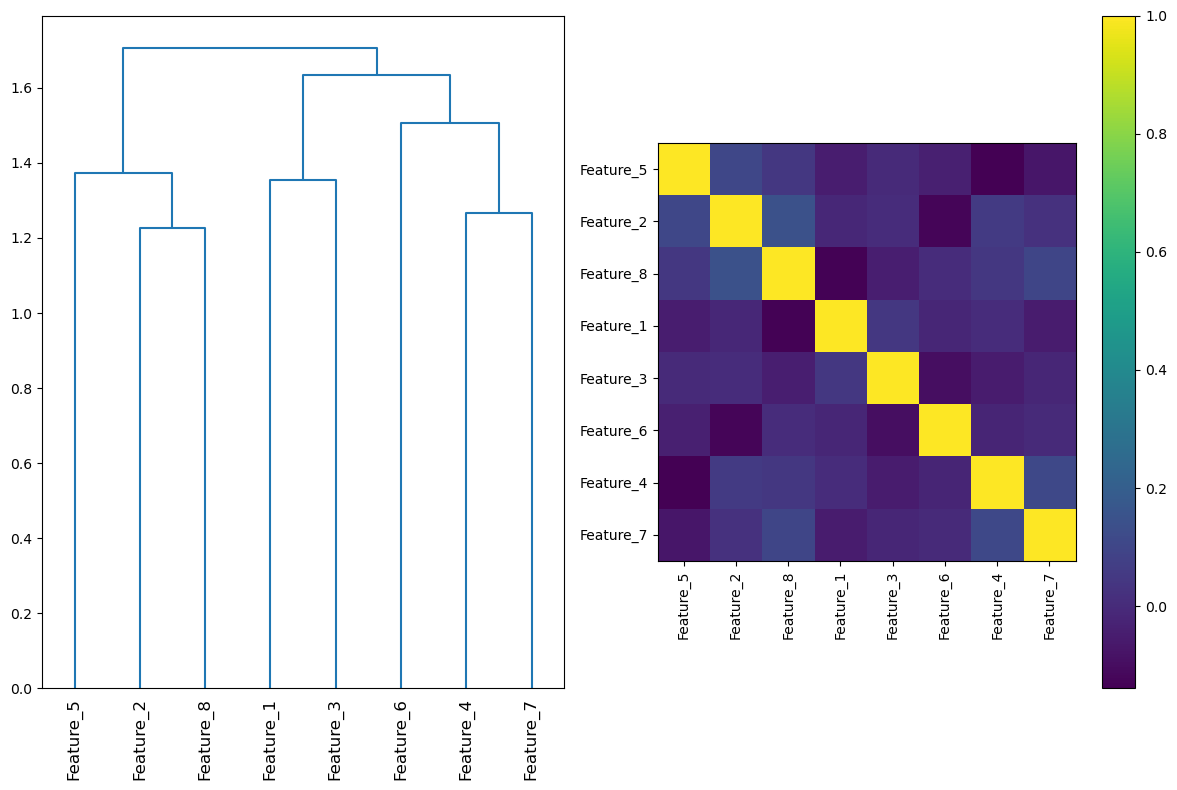

In [11]:
print("Calculate Spearman correlation matrix ...")
plot_feature_correlation_spearman(dfsim[feature_names_sim].values, feature_names_sim, outpath, show = True)

### Calculate Feature Importance Scores

In [12]:
fsel = selectio.Fsel(X, y)
dfresults = fsel.score_models()
# Add feature names
dfresults.insert(loc = 0, column = 'name_features', value = feature_names_sim)
# Print results
dfresults


Computing scores for model spearman...
Done, 3 features selected.
Computing scores for model mi...
Done, 6 features selected.
Computing scores for model xicor...
Done, 2 features selected.
Computing scores for model blr...
Done, 3 features selected.
Computing scores for model rf...
Done, 3 features selected.
Computing scores for model rdt...
Done, 8 features selected.


,name_features,score_spearman,score_mi,score_xicor,score_blr,score_rf,score_rdt,woe_spearman,woe_mi,woe_xicor,woe_blr,woe_rf,woe_rdt,score_combined,selected
0,Feature_1,0.3799,0.3447,0.4269,0.3845,0.4301,0.3919,1,1,1,1,1,1,0.3930,1
1,Feature_2,0.1987,0.0441,0.0000,0.2072,0.0531,0.0931,1,1,0,1,1,1,0.0994,1
2,Feature_3,0.0000,0.0320,0.0000,0.0000,0.0000,0.0162,0,1,0,0,0,1,0.0080,0
3,Feature_4,0.4214,0.4104,0.5731,0.4082,0.5168,0.4365,1,1,1,1,1,1,0.4611,1
4,Feature_5,0.0000,0.1247,0.0000,0.0000,0.0000,0.0145,0,1,0,0,0,1,0.0232,0
5,Feature_6,0.0000,0.0000,0.0000,0.0000,0.0000,0.0172,0,0,0,0,0,1,0.0029,0
6,Feature_7,0.0000,0.0000,0.0000,0.0000,0.0000,0.0166,0,0,0,0,0,1,0.0028,0
7,Feature_8,0.0000,0.0441,0.0000,0.0000,0.0000,0.0140,0,1,0,0,0,1,0.0097,0


### Generate feature importance plot for each model

Generating score plots ...


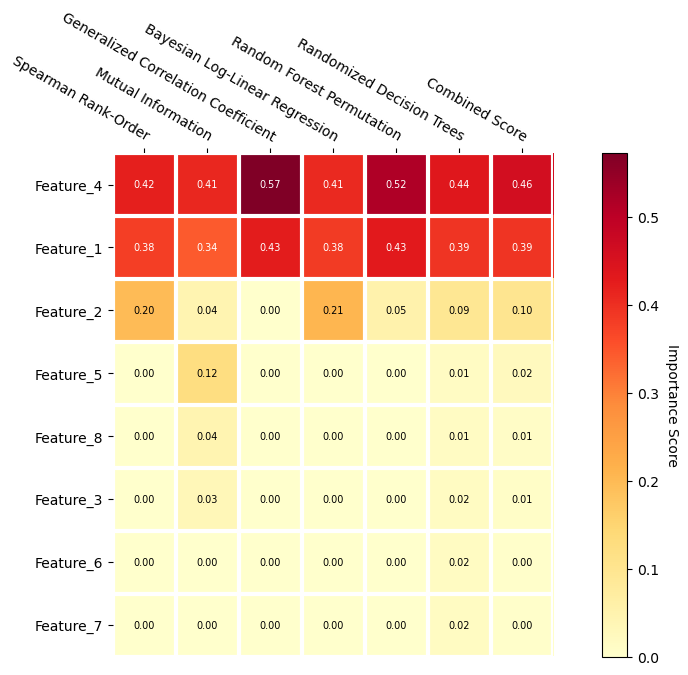

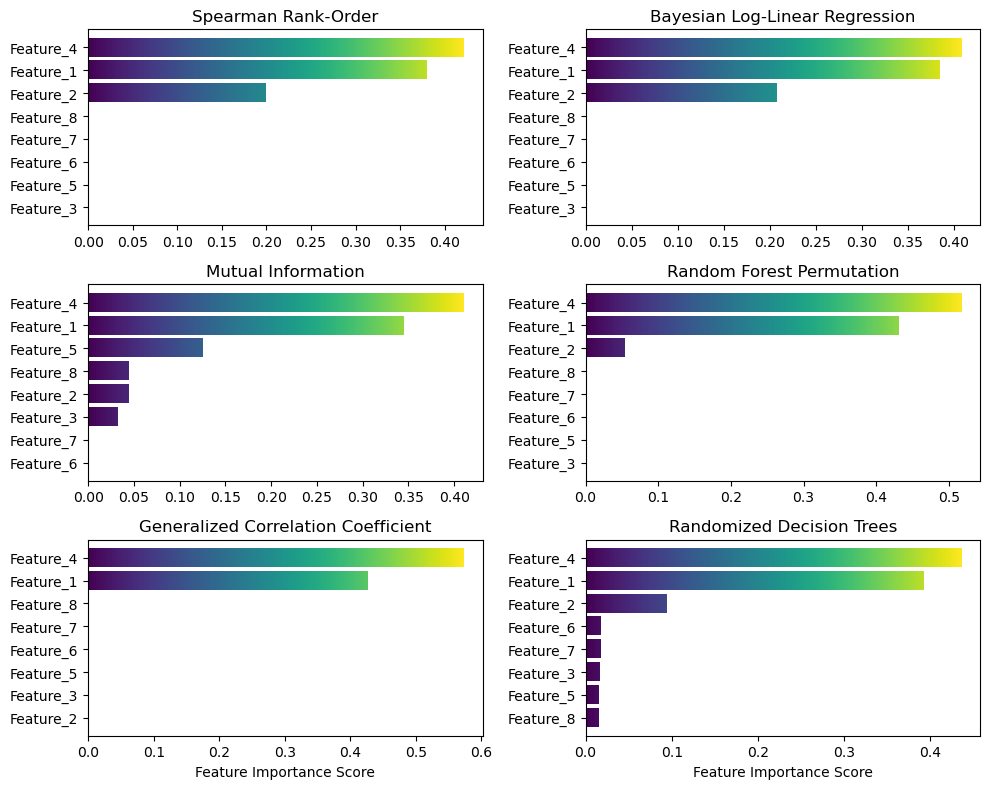

In [13]:
	# Plot scores
	print("Generating score plots ...")
	selectio.plot_allscores(dfresults, outpath, show = True)

### Plot combined score

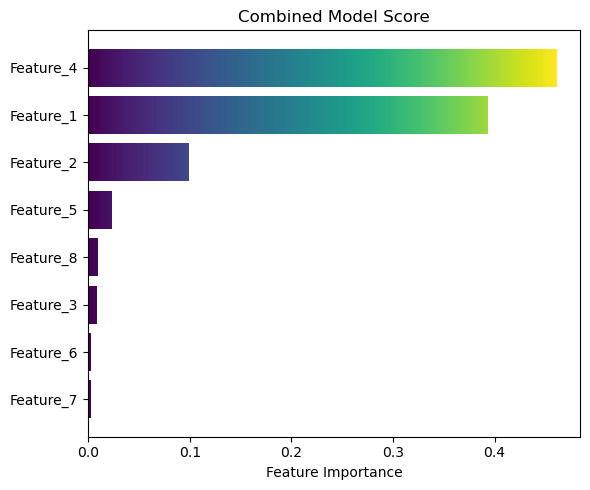

In [14]:
	scores_total = dfresults['score_combined'].values
	plot_correlationbar(scores_total, feature_names_sim, outpath, 'Combined-feature-importance.png', name_method = 'Combined Model Score', show = True)

### Print final selected features

In [15]:
# Show selected features only
dfselect = dfresults.loc[dfresults.selected == 1, ['name_features', 'score_combined']]
print('Selected Features:')
print(dfselect.sort_values('score_combined', ascending=False))


Selected Features:
  name_features  score_combined
3     Feature_4          0.4611
0     Feature_1          0.3930
1     Feature_2          0.0994
